# Spam Detection Project Reproduced One-to-One

# Reproducible Research Project

### Jakub Cudak
### Paulina Sereikyte
### Dawid Szyszko-Celinski

![alt text](https://www.netia.pl/Netia/media/blog/spam-co-to-jest.png)

Source: https://www.netia.pl/Netia/media/blog/spam-co-to-jest.png

## Aim of the initial project

The main aim of the project is to reproduce the econometric project submitted for the "Advanced Econometric" subject. The initial project idea was to create a logit and probit econometric model in RStudio that would predict if the email is spam. The dataset used for the initial analysis mainly consisted of certain keywords frequenies in the text and additional metrics such as a number of words in the email.

The approach of the modelling was as follows:
1) Create a basic probit and logit model that consists of all explanatory variables
2) Perform LR (likelihood Ratio) test to verify if the model`s parameters are jointly significant
3) Perform stepwise regression for both models to remove all coefficients whose p-value is above the 5% threshold
4) Again perform the LR test and additional Link test that would check if the model has a good specification
5) Add interaction between variables to the analysis
6) Perform stepwise regression
7) Execute LR and Link test
8) Execute the Hosmer-Lemershow test and Osjus-Rojek test to verify the specification
9) Verify goodness of fit statistics
10) Calculate marginal effects

The whole analysis and report can be found in the "Initial research" file:
1) The "Advanced Econometrics 2022 project" contains a report and description of the steps of the analysis
2) "spambase - raw data" consists of the raw dataset used for initial analysis
3) "Spam detection codes" - consist of R script used to perform the analysis
4) "names.csv" is an updated file with variables names, that can be read by R studio in CSV format
5) "linktest.R" and "marginaleffects.R" are custom functions written in R by dr Rafal Wozniak, Faculty of Economic Sciences, University of Warsaw

## Aim of this project

The aim of this project is to try reproducing the initial research in a different programming language - Python. We would like to verify if the actions performed in R can be easily translated into Python codes. We would like to verify if the outcomes are the same or if they differ due to possibly different algorithms that could be used in certain functions.

What is more, we would like to perform the same analysis, but on a different dataset with the same keyword that was used in the initial research. Based on the new dataset new keywords will be also obtained and a new model will be produced to verify how probit and logit models will work on the different datasets and keywords. The new dataset that will be used contains only text and labels if the message is spam or not, which is why it will be necessary to perform some data transformations. The process of the initial research will be followed.

In this part of the analysis we will try to recreate the previous research on the new data directly. We use an Email Spam Detection Dataset, which is available on Kaggle, and can be accessed via: https://www.kaggle.com/datasets/shantanudhakadd/email-spam-detection-dataset-classification

The dataset contains 5169 unique observations, out of which 87% are non-spam emails, while only 13% are classified as spam. While split is more challenging in terms of training our models, we can expect results to be less accurate. The e-mails in the dataset are not

The whole analysis can be found in the "Updated Research" file:
1) "Combined research" consists of a report and codes in jupyter notebook that contains all codes necessary to recreate initial research one-to-one and 2 updated versions: with old and new keywords on the new dataset.
2) "new_data_new_words.csv" dataset that will be used to analyse new keywords on a new dataset
3) "new_data_old_words.csv" dataset that will be used to analyse old keywords on a new dataset
4) "Technical" folder that contains all codes that were used as technical parts to create the main file "Combined research"
5) "Link to the dataset" - a text file containing a link to the new dataset

## General results

We were able to replicate the analysis, which was originally designed in R, in Python. Some adjustments had to be made to create new formulas and utilise a different set of packages, however the results generated in Python were the same as the results generated in R when using the same dataset.

Applying the same methodologies to a new dataset were more challenging, as the initial analysis was based on the word frequencies of certain words in the text. At first, the analysis was conducted based on the most common words and characters present in the new dataset. Then the models were replicated by calculating the frequencies of the words from the initial word list. 
While it was still possible to construct the models, they were generally less efficient in detecting spam. One of the main reasons was the much lower frequencies of the selected and previously used words in the new text. This resulted in very low variances within the variable which then had to be removed to be included in the models.
This issue was more prevalent when trying to replicate the analysis using the old word list - many of the words were highly specific to the initial dataset and thus were not found in the new data. This resulted in a big reduction in the number of variables and possible interactions, therefore the analysis could not be replicated exactly.

Overall, this excercise has proven what has been discussed in the initial research report- while econometric analysis performed well or on par with more complex models, it was determined to be highly specific to the data it was built on. As spam detection is a fast evolving subject that would need frequent updating and flexibility, other models, such as machine learning, are preferable.

## Disclaimer: AI Tools were used to reproduce the research

Our translation from R to Python was aided by the use of ChatGPT. The process involved an initial machine translation, after which we have fixed mistakes in subsequent iterations. ChatGPT provided also an alternative to Stack Overflow while searching for solutions to bugs we encountered. While using ChatGPT we have used queries that contained R code and the error messages.

Load the necessary packages

In [62]:
import os
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import patsy
from statsmodels.discrete.discrete_model import ProbitResults, LogitResults
from scipy.stats import chi2
from scipy.stats import norm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.preprocessing import MinMaxScaler

Import the initial dataset:

In [63]:
spam = pd.read_csv("/Inital research/spambase.data", header=None)
names = pd.read_csv("names.csv", header=None)

In [64]:
spam.describe

<bound method NDFrame.describe of         0     1     2    3     4     5     6     7     8     9   ...     48  \
0     0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.000   
1     0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.000   
2     0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.010   
3     0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.000   
4     0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.000   
...    ...   ...   ...  ...   ...   ...   ...   ...   ...   ...  ...    ...   
4596  0.31  0.00  0.62  0.0  0.00  0.31  0.00  0.00  0.00  0.00  ...  0.000   
4597  0.00  0.00  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.000   
4598  0.30  0.00  0.30  0.0  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.102   
4599  0.96  0.00  0.00  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.000   
4600  0.00  0.00  0.65  0.0  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.000   

         49   50 

In [65]:
names.describe

<bound method NDFrame.describe of                              0
0               word_freq_make
1            word_freq_address
2                word_freq_all
3                 word_freq_3d
4                word_freq_our
5               word_freq_over
6             word_freq_remove
7           word_freq_internet
8              word_freq_order
9               word_freq_mail
10           word_freq_receive
11              word_freq_will
12            word_freq_people
13            word_freq_report
14         word_freq_addresses
15              word_freq_free
16          word_freq_business
17             word_freq_email
18               word_freq_you
19            word_freq_credit
20              word_freq_your
21              word_freq_font
22               word_freq_000
23             word_freq_money
24                word_freq_hp
25               word_freq_hpl
26            word_freq_george
27               word_freq_650
28               word_freq_lab
29              word_freq_labs
30   

In [66]:
#rename columns

names.loc[48, 0] = "char_freq_semicolon"
names.loc[49, 0] = "char_freq_bracket"
names.loc[50, 0] = "char_freq_square_bracket"
names.loc[51, 0] = "char_freq_exclamation"
names.loc[52, 0] = "char_freq_dollar"
names.loc[53, 0] = "char_freq_hashtag"
names.loc[57, 0] = "spam"

In [67]:
#remove missing values

spam.columns = names[0].values

spam.dropna(inplace=True)

In [68]:
#overview of our database

spam.columns

Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',


Let us check the distribution of spam and non-spam mails

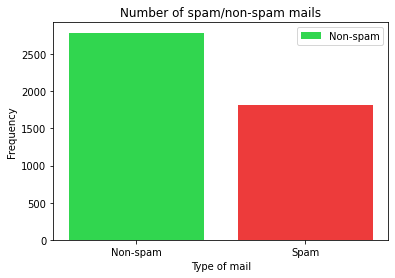

In [69]:
spam_count = spam["spam"].value_counts()
perc_yes = round(spam_count[1] / len(spam) * 100, 2)
perc_no = round(spam_count[0] / len(spam) * 100, 2)

plt.bar(["Non-spam", "Spam"], spam_count, color=["#31d64f", "#ed3b3b"])
plt.title("Number of spam/non-spam mails")
plt.xlabel("Type of mail")
plt.ylabel("Frequency")
plt.legend(["Non-spam", "Spam"])
plt.show()

We see that the dataset consists of 1813 observations in the “spam” category and 2788 in the “non-spam” category, providing a ca. 40/60 class distribution. Moreover, there are no missing values in the data.

## Start from the most general model that contains all explanatory variables

Create a formula that consists of all variables

In [70]:
formula = "spam ~ " + " + ".join(spam.columns[:-1])

We build two classification models, probit and logit, both binary dependent variable predictive models. 

Probit inital model

In [71]:
myprobit = sm.Probit.from_formula(formula, data=spam).fit()
print(myprobit.summary())

Optimization terminated successfully.
         Current function value: 0.207573
         Iterations 15
                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 4601
Model:                         Probit   Df Residuals:                     4543
Method:                           MLE   Df Model:                           57
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.6904
Time:                        22:37:48   Log-Likelihood:                -955.04
converged:                       True   LL-Null:                       -3085.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.8356      0.075    -11.098      0.000     

Logit initial model

In [72]:
mylogit = sm.Logit.from_formula(formula, data=spam).fit()
print(mylogit.summary())

Optimization terminated successfully.
         Current function value: 0.197323
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 4601
Model:                          Logit   Df Residuals:                     4543
Method:                           MLE   Df Model:                           57
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.7057
Time:                        22:37:49   Log-Likelihood:                -907.88
converged:                       True   LL-Null:                       -3085.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.5686      0.142    -11.044      0.000     

# Significance test of models coeeficients - LR test

H0: Beta1 = 0 & Beta2 = 0 & … & Beta57 = 0 (the general model can be simplified to restricted model based only on constant / all Betas are jointly insignificant)
H1: The general model cannot be simplified to a restricted model. All Betas are jointly significant.

Both models p-values are 0, so null hypothesis can be rejected. It means that for both models, the coefficients are jointly significant

In [73]:
null_probit = sm.Probit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probit likelihood ratio test p-value:", probit_lrtest)

Optimization terminated successfully.
         Current function value: 0.670523
         Iterations 4
Probit likelihood ratio test p-value: 0.0


In [74]:
null_logit = sm.Logit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

Optimization terminated successfully.
         Current function value: 0.670523
         Iterations 4
Logit likelihood ratio test p-value: 0.0


## Stepwise regression

As not all variables are individually significant, we perform the stepwise regression, which removes variables below the 5% significance threshold

In [75]:
p_probit = myprobit.pvalues
spam_temp_probit = spam.copy()

while any(p_probit > 0.05):
    worstp = p_probit.idxmax()
    
    print(worstp)
    spam_temp_probit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_probit.columns[:-1]:
        formula += f" + {column}"
    
    myprobit = sm.Probit.from_formula(formula, data=spam_temp_probit).fit()
    p_probit = myprobit.pvalues
    print(myprobit.aic)

word_freq_1999
Optimization terminated successfully.
         Current function value: 0.207573
         Iterations 15
2024.088917331387
word_freq_people
Optimization terminated successfully.
         Current function value: 0.207579
         Iterations 15
2022.1381806395907
word_freq_415


Optimization terminated successfully.
         Current function value: 0.207587
         Iterations 15
2020.2155613834486
capital_run_length_average
Optimization terminated successfully.
         Current function value: 0.207597
         Iterations 15
2018.3090124810756
word_freq_telnet
Optimization terminated successfully.
         Current function value: 0.207632
         Iterations 15
2016.6278326615745
word_freq_receive
Optimization terminated successfully.
         Current function value: 0.207662
         Iterations 15
2014.9078328699995
word_freq_direct
Optimization terminated successfully.
         Current function value: 0.207723
         Iterations 15
2013.4677960927206
word_freq_857
Optimization terminated successfully.
         Current function value: 0.207781
         Iterations 15
2011.9973433071923
char_freq_bracket
Optimization terminated successfully.
         Current function value: 0.207870
         Iterations 15
2010.8215432666034
char_freq_square_bracket
Optimizati

In [76]:
p_logit = mylogit.pvalues
spam_temp_logit = spam.copy()

while any(p_logit > 0.05):
    worstp = p_logit.idxmax()
    
    print(worstp)
    spam_temp_logit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_logit.columns[:-1]:
        formula += f" + {column}"
    
    mylogit = sm.Logit.from_formula(formula, data=spam_temp_logit).fit()
    p_logit = mylogit.pvalues
    print(mylogit.aic)

word_freq_1999


Optimization terminated successfully.
         Current function value: 0.197330
         Iterations 15
1929.8351001472463
word_freq_telnet
Optimization terminated successfully.
         Current function value: 0.197358
         Iterations 15
1928.0866448894978
word_freq_people
Optimization terminated successfully.
         Current function value: 0.197372
         Iterations 15
1926.2137629946117
word_freq_415
Optimization terminated successfully.
         Current function value: 0.197392
         Iterations 15
1924.4056155735882
capital_run_length_average
Optimization terminated successfully.
         Current function value: 0.197440
         Iterations 15
1922.846172866969
char_freq_bracket
Optimization terminated successfully.
         Current function value: 0.197500
         Iterations 15
1921.3991742674934
word_freq_857
Optimization terminated successfully.
         Current function value: 0.197573
         Iterations 15
1920.0647903082443
char_freq_square_bracket
Optimization te

## Link test - it verifies the model specification

If yhat is significant and yhat2 is not signifficant: model has a good specification

If yhat is / is not significant and yhat2 is signifficant: model does not have a good specification

The defined functions were recreated from R codes that can be found in the "Initial Research" folder on GitHub. The functions were written by dr Rafal Wozniak, Faculty of Economic Sciences, University of Warsaw

In [77]:
def linktest_probit(model):
    """
    Function to perform linktest on a logistic regression model.
    
    Args:
    - model: logistic regression model object
    
    Returns:
    - aux_reg: auxiliary regression model object
    """
    
    # Prepare the data
    y = model.model.endog
    pred = model.predict()
    pred = np.clip(pred, 1e-12, 1 - 1e-12)
    yhat = np.log(pred/(1-pred))
    yhat2 = yhat**2

    # Add constant column to predictor variables
    X = np.column_stack((np.ones_like(y), yhat, yhat2))

    # Remove rows with missing or infinite values
    valid_idx = np.isfinite(X).all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]

    # Fit the binomial regression model
    model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.probit()))
    result = model.fit()
    
    return result

In [78]:
def linktest_logit(model):
    """
    Function to perform linktest on a logistic regression model.
    
    Args:
    - model: logistic regression model object
    
    Returns:
    - aux_reg: auxiliary regression model object
    """
    
    # Prepare the data
    y = model.model.endog
    pred = model.predict()
    pred = np.clip(pred, 1e-12, 1 - 1e-12)
    yhat = np.log(pred/(1-pred))
    yhat2 = yhat**2

    # Add constant column to predictor variables
    X = np.column_stack((np.ones_like(y), yhat, yhat2))

    # Remove rows with missing or infinite values
    valid_idx = np.isfinite(X).all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]

    # Fit the binomial regression model
    model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
    result = model.fit()
    
    return result

In [79]:
# Linktest for probit model - after stepwise regression
linktest_result_probit = linktest_probit(myprobit)
print(linktest_result_probit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4598
Model Family:                Binomial   Df Model:                            2
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 18 Jun 2023   Deviance:                       34907.
Time:                        22:38:17   Pearson chi2:                 1.71e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.972e+12    1.4e+05  -3.54e+07      0.0

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


In [80]:
# Linktest for logit model - after stepwise regression
linktest_result_logit = linktest_logit(mylogit)
print(linktest_result_logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4598
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -940.83
Date:                Sun, 18 Jun 2023   Deviance:                       1881.7
Time:                        22:38:17   Pearson chi2:                 7.32e+09
No. Iterations:                    16   Pseudo R-squ. (CS):             0.6063
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0902      0.060      1.501      0.1

Based on the previousle mentioned criteria both model does not have good specification. The results are the same as in R.

The next thing to consider is adding interaction terms to the models, so that it may help with the correct specification.

### Interaction terms
Adding interaction terms and deleting insignificant ones for probit.

In [81]:
formula_interactions = "spam ~ word_freq_make * word_freq_address * word_freq_our + word_freq_over + word_freq_remove + word_freq_internet * word_freq_order * word_freq_free * word_freq_business + word_freq_you + word_freq_credit * word_freq_your + word_freq_000 + word_freq_money + word_freq_hp + word_freq_hpl + word_freq_george + word_freq_650 + word_freq_data + word_freq_85 + word_freq_technology + word_freq_pm + word_freq_meeting + word_freq_project + word_freq_re + word_freq_edu + word_freq_conference + char_freq_semicolon * char_freq_exclamation * char_freq_dollar * char_freq_hashtag + capital_run_length_longest + capital_run_length_total"

mylogit = sm.formula.glm(formula_interactions, data=spam, family=sm.families.Binomial(sm.genmod.families.links.logit())).fit()

p = mylogit.pvalues
print(p)

Intercept                                                                       2.345811e-40
word_freq_make                                                                  3.224714e-03
word_freq_address                                                               4.307141e-02
word_freq_make:word_freq_address                                                8.881067e-01
word_freq_our                                                                   2.474520e-06
                                                                                    ...     
char_freq_semicolon:char_freq_dollar:char_freq_hashtag                          5.911354e-01
char_freq_exclamation:char_freq_dollar:char_freq_hashtag                        8.673990e-01
char_freq_semicolon:char_freq_exclamation:char_freq_dollar:char_freq_hashtag    4.725009e-01
capital_run_length_longest                                                      1.011262e-11
capital_run_length_total                                              

In [82]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        X = patsy.dmatrix(formula_interactions, data=spam)

        # Convert the design matrix to a DataFrame
        X = pd.DataFrame(X, columns=X.design_info.column_names)
        i=2
    else:
        X = X.drop(worstp, axis=1)
        X_names = ['Intercept'] + list(X.columns)[1:]
        X.columns = X_names

        mylogit = sm.GLM(spam['spam'], X, family=sm.families.Binomial(sm.families.links.logit())).fit()

        p = mylogit.pvalues
        print(mylogit.aic)

word_freq_make:word_freq_address


word_freq_make:word_freq_address
1920.299552620765
word_freq_free:word_freq_business
1918.3214384510645
char_freq_exclamation:char_freq_dollar:char_freq_hashtag
1916.348191039537
char_freq_dollar:char_freq_hashtag
1914.4148815341832
word_freq_internet:word_freq_order
1912.4856492302165
char_freq_semicolon:char_freq_dollar
1910.5750425935366
char_freq_semicolon
1908.6438618622913
word_freq_internet:word_freq_order:word_freq_free
1907.0447361830134
word_freq_order:word_freq_free:word_freq_business
1905.190842218639
char_freq_semicolon:char_freq_exclamation:char_freq_hashtag
1903.310937284863
word_freq_internet:word_freq_order:word_freq_free:word_freq_business
1902.5509796521967
char_freq_semicolon:char_freq_dollar:char_freq_hashtag
1904.0768697569106
word_freq_internet:word_freq_free:word_freq_business
1902.9043406399896
word_freq_make:word_freq_address:word_freq_our
1901.8527243664184
word_freq_internet:word_freq_order:word_freq_business
1902.6999170599224
word_freq_internet:word_freq_b

In [83]:
print(mylogit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   spam   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4561
Model Family:                Binomial   Df Model:                           39
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -913.54
Date:                Sun, 18 Jun 2023   Deviance:                       1827.1
Time:                        22:38:29   Pearson chi2:                 3.35e+06
No. Iterations:                    12   Pseudo R-squ. (CS):             0.6109
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

The used varaibles in the model are exactly the same as in R

In [84]:
null_logit = sm.Logit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

linktest_result_logit = linktest_logit(mylogit)
print("LinkTest result", linktest_result_logit.summary())

Optimization terminated successfully.
         Current function value: 0.670523
         Iterations 4
Logit likelihood ratio test p-value: 0.0
LinkTest result                  Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4598
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -913.31
Date:                Sun, 18 Jun 2023   Deviance:                       1826.6
Time:                        22:38:29   Pearson chi2:                 2.82e+07
No. Iterations:                    11   Pseudo R-squ. (CS):             0.6109
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>

It seems that yhat is significant and yhat squared is not - this means that now updated model with interactions is correctly specified. The same results were obtained in the initial research.

Now let us test the probit model with interactions

In [85]:
formula_interactions = "spam ~ word_freq_free + word_freq_order + word_freq_receive + char_freq_hashtag * char_freq_exclamation + word_freq_telnet + word_freq_technology + word_freq_conference * word_freq_edu + word_freq_hp + word_freq_money + word_freq_credit + word_freq_000 + char_freq_dollar + word_freq_your * word_freq_email * word_freq_address + word_freq_people + word_freq_mail + word_freq_george + word_freq_our * word_freq_meeting"

myprobit = sm.Probit.from_formula(formula=formula_interactions, data=spam).fit()

p = myprobit.pvalues
print(p)

Optimization terminated successfully.
         Current function value: 0.268006
         Iterations 13
Intercept                                           1.060829e-58
word_freq_free                                      2.013689e-27
word_freq_order                                     3.707155e-05
word_freq_receive                                   5.922157e-01
char_freq_hashtag                                   4.317635e-02
char_freq_exclamation                               6.030368e-08
char_freq_hashtag:char_freq_exclamation             9.817137e-05
word_freq_telnet                                    1.765068e-01
word_freq_technology                                1.495378e-03
word_freq_conference                                4.159086e-03
word_freq_edu                                       1.100515e-15
word_freq_conference:word_freq_edu                  5.262433e-01
word_freq_hp                                        8.853227e-28
word_freq_money                                     

In [86]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        Z = patsy.dmatrix(formula_interactions, data=spam)

        # Convert the design matrix to a DataFrame
        Z = pd.DataFrame(Z, columns=Z.design_info.column_names)
        i=2
    else:
        Z = Z.drop(worstp, axis=1)
        Z_names = ['Intercept'] + list(Z.columns)[1:]
        Z.columns = Z_names

        myprobit = sm.Probit(spam['spam'], Z).fit()

        p = myprobit.pvalues
        print(myprobit.aic)

word_freq_our:word_freq_meeting
word_freq_our:word_freq_meeting
Optimization terminated successfully.
         Current function value: 0.268018
         Iterations 13


2524.3003032611086
word_freq_receive
Optimization terminated successfully.
         Current function value: 0.268049
         Iterations 13
2522.5914836613906
word_freq_conference:word_freq_edu
Optimization terminated successfully.
         Current function value: 0.268100
         Iterations 13
2521.054837918212
word_freq_telnet
Optimization terminated successfully.
         Current function value: 0.268471
         Iterations 13
2522.4738070364815
word_freq_people
Optimization terminated successfully.
         Current function value: 0.268673
         Iterations 13
2522.325516194447
word_freq_your:word_freq_email
Optimization terminated successfully.
         Current function value: 0.269005
         Iterations 13
2523.385000656226
char_freq_hashtag
Optimization terminated successfully.
         Current function value: 0.269430
         Iterations 13
2525.290846978696


In [87]:
print(myprobit.summary())

                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 4601
Model:                         Probit   Df Residuals:                     4578
Method:                           MLE   Df Model:                           22
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.5982
Time:                        22:38:30   Log-Likelihood:                -1239.6
converged:                       True   LL-Null:                       -3085.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -0.7396      0.046    -16.142      0.000      -0.829      -0.650
word_freq_free   

In [88]:
null_probit = sm.Probit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
logit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probitlikelihood ratio test p-value:", probit_lrtest)

linktest_result_probit = linktest_probit(myprobit)
print("LinkTest result", linktest_result_probit.summary())

Optimization terminated successfully.
         Current function value: 0.670523
         Iterations 4
Probitlikelihood ratio test p-value: 0.0
LinkTest result                  Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4598
Model Family:                Binomial   Df Model:                            2
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 18 Jun 2023   Deviance:                       57288.
Time:                        22:38:30   Pearson chi2:                 2.80e+18
No. Iterations:                    30   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


Bot yhat and yhat squared are significant - the specification of the model is not correct

## As in previous study the Link Test and LR test draw attention to the logit model with interactions that was well specified and significant
### Now let us perform other tests for the model

In [89]:
gof_results = mylogit.deviance
print("Goodness-of-Fit Test:")
print("Deviance: ", gof_results)

Goodness-of-Fit Test:
Deviance:  1827.0817098338612


## Hosmer-Lemershow test - for specification
## Source: https://stackoverflow.com/questions/40327399/hosmer-lemeshow-goodness-of-fit-test-in-python
### Results are in line with our calculations performed originally in R

In [90]:
predictions = mylogit.predict()
Y = mylogit.model.endog

hl_df = pd.DataFrame({

"P_i": predictions,
"Outcome": Y

})

hl_df["decile"] = pd.qcut(hl_df["P_i"],10)
obsevents_1 = hl_df["Outcome"].groupby(hl_df.decile).sum()
obsevents_0 = hl_df["Outcome"].groupby(hl_df.decile).count() - obsevents_1
expevents_1 = hl_df["P_i"].groupby(hl_df.decile).sum()
expevents_0 = hl_df["P_i"].groupby(hl_df.decile).count() - expevents_1
hl = (((obsevents_0 - expevents_0)**2)/(expevents_0)).sum() + (((obsevents_1 - expevents_1)**2)/(expevents_1)).sum()
pvalue = 1 - chi2.cdf(hl , 10 - 2)

print('HL test:', pvalue)

HL test: 0.0


## Osius-Rojek Test - the only part of code that could not be reproduced as we were not able to find the function in Python nor write with help of the Internet

### The code visible in the bottom were produced by chat gpt based on the description in R function:

Osius and Rojek's tests
These are based on a power-divergence statistic PD[l] (l=1 for Pearsons test) and the standard deviation (herein, of a binomial distribution) SD. The statistic is:

Z[OR] = PD[l] - lbar / SD[l]


For logistic regression, it is calculated as:

Z[OR] = (chiSq - (n - p)) / (2 * n * SUM 1/n[i])^0.5

where RSS is the residual sum-of-squares from a weighted linear regression:

(1 - 2 * P[i]) / SD[i] ~ X, weights = SD[i]

Here \bold{X} is the matrix of model predictors.
A two-tailed test against a standard normal distribution N ~ (0, 1) should not be significant.

Source: Osius G & Rojek D, 1992. Normal goodness-of-fit tests for multinomial models with large degrees of freedom. Journal of the American Statistical Association. 87(420):1145-52. doi: 10.1080/01621459.1992.10476271. Also available at JSTOR at https://www.jstor.org/stable/2290653

In [91]:
result = mylogit
pred_probs = result.predict()

epsilon = 1e-12
pred_probs = np.clip(pred_probs, epsilon, 1-epsilon)

# Calculate the residuals
residuals = (1 - 2 * pred_probs) / np.sqrt(pred_probs * (1 - pred_probs))

# Calculate the standard deviation of a binomial distribution (SD)
sd = np.sqrt(np.mean(pred_probs * (1 - pred_probs)))

# Calculate the residual sum of squares (RSS)
rss = np.sum(residuals**2)

# Calculate the chi-square value
chi_sq = result.llf * -2

# Calculate the test statistic Z[OR]
n = len(result.model.endog)
p = result.df_model
test_statistic = (chi_sq - p) / np.sqrt(2 * p)

## Value obatined from R - good one
#test_statistic = 0.1730284

# Calculate the p-value based on a two-tailed test against a standard normal distribution
p_value = 1 - stats.norm.cdf(test_statistic)

print("Test Statistic: ", test_statistic)
print("P-value: ", p_value)

Test Statistic:  202.4603855218882
P-value:  0.0


## McFadden pseudo R-squared

McFadden's Pseudo-R-squared measures how well our model fits the data by calculating the ratio of the log likelihood for the model and an intercept-only model. The result is presented by subtracting the result from 1.

In [92]:
# Pseudo R-squared
pseudo_r2 = 1 - (mylogit.llf / mylogit.llnull)
print("Pseudo R-squared: ", pseudo_r2)

Pseudo R-squared:  0.7038838814093342


We also calculated the count statistic, which was fully in line with the outcomes produced in R

In [94]:
pred_probs = result.predict()
y_observed = result.model.endog

# Round predicted probabilities to 0 or 1 based on the cutoff of 0.50
pred_classes = np.where(pred_probs > 0.50, 1, 0)

# Calculate the number of correctly classified cases
correctly_classified = np.sum(pred_classes == y_observed)

# Calculate the total number of cases
total_cases = len(y_observed)

# Calculate the count pseudo R-squared
count_r2 = correctly_classified / total_cases

# Calculate the number of predictors in the model
p = result.df_model

# Print the pseudo R-squared statistics
print("Count Pseudo R-squared: ", count_r2)

Count Pseudo R-squared:  0.9280591175831341


## Marginal effects
Source: https://gist.github.com/BioSciEconomist/e5e6cd377ee8ccd565db967e76a58088

In [95]:
# home grown marginal effects function for logit model with 2 variables

def mfx(result,mu1,mu2,par):
    """
    result: model object from stats models logistic regression
    ex: y ~ b0 + b1*x1 + b2*x2
    mu1: mean value for first variable in model
    mu2: mean value for 2nd variable in model
    par: indicates index from 0 for model parameter you want to convert to a 
         marginal effect
    note: this easily extends to more variables but does not handle predictors
          with multiple categories (unless they are dummy coded)
    """
    b0 =  result.params[0]  
    b1 =  result.params[1] 
    b2 =  result.params[2] 
    XB = mu1*b1 + mu2*b2 + b0 
    return (np.exp(XB)/((1+np.exp(XB))**2))*result.params[par]


mfx(result,.5,30,1) # home grown function gives almost
                    # exact same result as get_margeff() above

-0.0008757521280584903

In [96]:
def mfx(result, *means, par):
    """
    result: model object from statsmodels logistic regression
    means: mean values for each variable in the model (in the same order as the coefficients)
    par: index of the model parameter you want to convert to a marginal effect
    """
    b0 = result.params[0]
    params = result.params[1:]  # Exclude the intercept
    XB = b0 + np.dot(params, means)
    exp_XB = np.exp(XB)
    marginal_effect = (exp_XB / ((1 + exp_XB) ** 2)) * result.params[par]
    return marginal_effect

In [97]:
X['spam'] = spam['spam']
last_column = X.columns[-1]  # Get the name of the last column
columns = [last_column] + list(X.columns[:-1])  # Create a new list of column names with the last column at the front
X = X[columns]  # Reorder the columns in the DataFrame

# Replace the colon with a multiplication sign in the column name
X.rename(columns={'char_freq_semicolon:char_freq_exclamation' : 'char_freq_semicolon_char_freq_exclamation'}, inplace=True)
X.rename(columns={'char_freq_semicolon:char_freq_hashtag' : 'char_freq_semicolon_char_freq_hashtag'}, inplace=True)
X.rename(columns={'word_freq_credit:word_freq_your' : 'word_freq_credit_word_freq_your'}, inplace=True)
X.rename(columns={'word_freq_address:word_freq_our' : 'word_freq_address_word_freq_our'}, inplace=True)
X.rename(columns={'word_freq_order:word_freq_free' : 'word_freq_order_word_freq_free'}, inplace=True)
X.rename(columns={'word_freq_order:word_freq_business' : 'word_freq_order_word_freq_business'}, inplace=True)
X.rename(columns={'char_freq_exclamation:char_freq_dollar' : 'char_freq_exclamation_char_freq_dollar'}, inplace=True)

epsilon = 1e-8

X = X.replace(0, epsilon)

# Fit the logistic regression model
model = smf.logit(formula='spam ~ word_freq_make+word_freq_address+word_freq_our+word_freq_address_word_freq_our+word_freq_over+word_freq_remove+word_freq_internet+word_freq_order+word_freq_free+word_freq_order_word_freq_free+word_freq_business+word_freq_order_word_freq_business+word_freq_you+word_freq_credit+word_freq_your+word_freq_credit_word_freq_your+word_freq_000+word_freq_money+word_freq_hp+word_freq_hpl+word_freq_george+word_freq_650+word_freq_data+word_freq_85+word_freq_technology+word_freq_pm+word_freq_meeting+word_freq_project+word_freq_re+word_freq_edu+word_freq_conference+char_freq_exclamation+char_freq_semicolon_char_freq_exclamation+char_freq_dollar+char_freq_exclamation_char_freq_dollar+char_freq_hashtag+char_freq_semicolon_char_freq_hashtag', data=X).fit()
print(model.summary())

# Get marginal effects
margeff_overall = model.get_margeff(at='overall')
print(margeff_overall.summary())

Optimization terminated successfully.
         Current function value: 0.210805
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 4601
Model:                          Logit   Df Residuals:                     4563
Method:                           MLE   Df Model:                           37
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.6856
Time:                        22:39:13   Log-Likelihood:                -969.92
converged:                       True   LL-Null:                       -3085.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    

The marginal effects were a little different due to the fact that we have to exclude 2 variables that could not be used in Python function. However, the results were relatively simillar, with the same sing of coefficients and signifficance of p-values.

## In summary, we have demonstrated the replicability of our approach through the use of an alternative programming language - the discrepancies were minor and resulted from differences in the implementation of models between R and Python.

# Spam Detection Project - new data & new keywords

### Data preprocessing part

* Data exploration - let us check how the columns look like and delete unnecessary ones and then move to preprocessing
* We dont need the first column 'Unnamed: 0' as it is just an ID
* The columns 'label' and 'label_num' depict the same thing, let us only leave 'label_num' that represent spam (1) and non-spam (0) label

Import the dataset:

In [98]:
data = pd.read_csv(r"C:\Users\justy\Desktop\Info\Inne\DSC\UW\Semestr IV\RR\RR_Project\Updated Research\spam.csv", encoding = "latin")

In [99]:
data = data[["v1", "v2"]]

In [100]:
data.columns

Index(['v1', 'v2'], dtype='object')

In [101]:
data.rename({"v1": "spam", "v2":"text"}, axis = 1, inplace = True)

In [102]:
data.describe()

,spam,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Data preprocessing - we only need to take care of the text column
Convert text to lowercase - the iteration is required to go through each mail (it seems that the text was already in lower case but just to make sure let us do it again)

In [103]:
data['text'][0]

for i in range(0,len(data)):
    data['text'][i] = data['text'][i].lower()

## Check if it worked

data['text'][0]

'go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...'

## Word Frequency

The previous analysis was based on word frequencies appearing in the text. In order to obtain the right word frequencies, we have to remove the stopwords as well as conduct lemmantization to obtain the root of the word and reduce the number of unique words. 
Next, we count the occurence of the top 50 most frequent words, special characters and numbers in each email.

We generate the functions with the help of ChatGPT.

In [106]:
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    
    # Lemmatize each word and remove stop words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
    
    # Join the lemmatized words back into a single string
    processed_text = ' '.join(lemmatized_words)
    
    return processed_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\justy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\justy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
data['processed_text'] = data['text'].apply(preprocess_text)

LookupError: 
**********************************************************************
  Resource [93momw-1.4[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('omw-1.4')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/omw-1.4[0m

  Searched in:
    - 'C:\\Users\\justy/nltk_data'
    - 'c:\\Users\\justy\\AppData\\Local\\Programs\\Python\\Python39\\nltk_data'
    - 'c:\\Users\\justy\\AppData\\Local\\Programs\\Python\\Python39\\share\\nltk_data'
    - 'c:\\Users\\justy\\AppData\\Local\\Programs\\Python\\Python39\\lib\\nltk_data'
    - 'C:\\Users\\justy\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


The words are tokenized excluding the numbers (as random selection of integers were appearing in the top 50). We obtain the 50 most frequent ones.

In [108]:
# Tokenize the text into words while excluding numbers
all_text = data['processed_text'].str.cat(sep=' ')
words = nltk.word_tokenize(all_text)
words = [word for word in words if word.isalpha()]

# Create a frequency distribution of the words
freq_dist = FreqDist(words)

# Retrieve the most common words
num_most_common = 50
most_common_words = freq_dist.most_common(num_most_common)

# Print the most common words and their frequencies
for word, frequency in most_common_words:
    print(word, frequency)


KeyError: 'processed_text'

A list of only the needed words is obtained.

In [ ]:
word_list = [word for word, count in most_common_words]

We generate a word frequency matrix for the most common words, as well as adding additional columns for special characters and integers.

In [ ]:
vectorizer = CountVectorizer(vocabulary=word_list)
X = vectorizer.fit_transform(data["processed_text"])

In [ ]:
matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data = pd.concat([data[["processed_text", "spam"]], matrix], axis=1)

In [ ]:
for char in ["$", "€", "!", "@", "?"]:
    pattern = re.escape(char)  # Escape special characters in the regex pattern
    data[char] = data["processed_text"].str.count(pattern)

data["digit_count"] = data["processed_text"].str.count(r"\d")

In [ ]:
columns_to_scale = data.columns[2:57]

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the selected columns
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Display the scaled DataFrame
data

In [ ]:
data.to_csv(r"\new_data_new_words.csv")

# Word frequencies from previous analysis

We also want to create a word frequency matrix with the words used in the previous analysis. We calculate the frequencies as well as dividing them by the total number of words in the text to match the previous dataset.

In [ ]:
data_old = pd.DataFrame(data[["processed_text", "spam"]])

words_old = ['make', 'address', 'all', '3d', 'our', 'over', 'remove', 'internet','order',
             'mail', 'receive', 'will', 'people', 'report', 'addresses','free', 'business',
             'email', 'you', 'credit', 'your', 'font', '000', 'money', 'hp','hpl','george',
             '650', 'lab', 'labs', 'telnet', '857', 'data', '415', '85', 'technology', '1999', 
             'parts', 'pm', 'direct', 'cs', 'meeting', 'original', 'project', 're', 'edu', 'table',
             'conference', ';', '(', '[', '!', '$', '#']

In [ ]:
for char in words_old:
    pattern = re.escape(char)  # Escape special characters in the regex pattern
    data_old[char] = data["processed_text"].str.count(pattern)

In [ ]:
data_old["word_count"] = data_old["processed_text"].apply(lambda x: len(x.split()))

In [ ]:
data_old[words_old] = data_old[words_old].div(data_old["word_count"], axis=0)

In [ ]:
data_old.to_csv(r"\new_data_old_words.csv")

# The next part of the process was testing the approach on a new dataset

The analysis will be conducted using word frequencies from the old research as well as a new word list from the new datsaset. 

## New Data New Words

Import and prepare the dataset for analysis:

In [109]:
spam = pd.read_csv("Updated Research/new_data_new_words.csv")
spam.dropna(inplace = True)

#Renaming character columns to a less error-prone form
spam.rename(columns = {'$':'dollar',
                       '!': 'exclamation',
                      "#": "hashtag",
                       "(":"parenthesis",
                       "[": "brackets",
                       ";": "semicolon",
                       "€": "euro",
                       "@": "at", 
                       "?": "question"
                      }, inplace = True)

#Drop columns not neccessary to the analysis
spam.drop(columns=['Unnamed: 0', 'processed_text', 'word_count'], inplace = True)

#Rename columns to include word_freq
column_names = spam.columns.tolist()
new_column_names = ['spam'] + ['word_freq_' + column if column != 'spam' else column for column in column_names[1:]]

spam.rename(columns=dict(zip(column_names, new_column_names)), inplace=True)

#Convert the dependent variable to a numeric one
spam['spam'] = spam['spam'].replace({
    'spam': 1,
    'ham': 0})

In [110]:
spam.describe

<bound method NDFrame.describe of       spam  word_freq_u  word_freq_call  word_freq_get  word_freq_ur  \
0        0          0.0            0.00            0.0           0.0   
1        0          0.0            0.00            0.0           0.0   
2        1          0.0            0.00            0.0           0.0   
3        0          0.0            0.00            0.0           0.0   
4        0          0.0            0.00            0.0           0.0   
...    ...          ...             ...            ...           ...   
5567     1          0.0            0.08            0.0           0.0   
5568     0          0.0            0.00            0.0           0.0   
5569     0          0.0            0.00            0.0           0.0   
5570     0          0.0            0.00            0.0           0.0   
5571     0          0.0            0.00            0.0           0.0   

      word_freq_gt  word_freq_lt  word_freq_go  word_freq_free  \
0              0.0           0.0   

Very low variances in independent variables cause errors in the models. We set a treshold for the variances of the columns and keep only the columns that can be included in the analysis. This part was necessary for models to return propper values insted of Nan

In [111]:
variance = spam.var()

# Set the threshold value
threshold = 0.003

# Filter columns based on variance threshold
filtered_columns = variance[variance >= threshold].index

# Create a new DataFrame with selected columns
spam = spam[filtered_columns]

spam.var()

spam                      0.116111
word_freq_call            0.005306
word_freq_get             0.003488
word_freq_ur              0.003405
word_freq_gt              0.007387
word_freq_lt              0.009940
word_freq_go              0.004034
word_freq_free            0.004759
word_freq_come            0.003268
word_freq_day             0.003685
word_freq_time            0.003465
word_freq_text            0.004684
word_freq_love            0.003443
word_freq_send            0.003109
word_freq_need            0.003308
word_freq_going           0.004255
word_freq_sorry           0.004954
word_freq_still           0.004305
word_freq_take            0.003129
word_freq_da              0.004420
word_freq_dont            0.003515
word_freq_later           0.007791
word_freq_exclamation     0.003834
word_freq_digit_count    38.995783
dtype: float64

Let us check the distribution of spam and non-spam mails

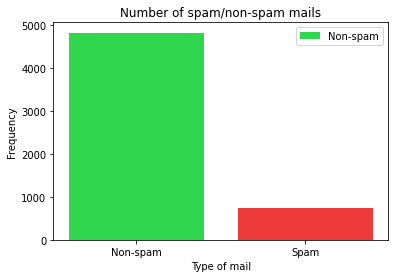

In [112]:
spam_count = spam["spam"].value_counts()
perc_yes = round(spam_count[1] / len(spam) * 100, 2)
perc_no = round(spam_count[0] / len(spam) * 100, 2)

plt.bar(["Non-spam", "Spam"], spam_count, color=["#31d64f", "#ed3b3b"])
plt.title("Number of spam/non-spam mails")
plt.xlabel("Type of mail")
plt.ylabel("Frequency")
plt.legend(["Non-spam", "Spam"])
plt.show()

## Start from the most general model that contains all explanatory variables

In [113]:
formula = "spam ~ " + " + ".join(spam.columns[1:])

### Probit model
---

In [115]:
myprobit = sm.Probit.from_formula(formula, data=spam).fit()
print(myprobit.summary())

         Current function value: 0.084801
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                         Probit   Df Residuals:                     5548
Method:                           MLE   Df Model:                           23
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.7848
Time:                        22:55:38   Log-Likelihood:                -472.51
converged:                      False   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.2321      0.061    -36.431      0.000      -2.352      -2.112
word_freq_call           -3.0682

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Logit model
---

In [116]:
mylogit = sm.Logit.from_formula(formula, data=spam).fit()
print(mylogit.summary())

         Current function value: 0.084299
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                          Logit   Df Residuals:                     5548
Method:                           MLE   Df Model:                           23
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.7861
Time:                        22:55:55   Log-Likelihood:                -469.72
converged:                      False   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.2063      0.143    -29.436      0.000      -4.486      -3.926
word_freq_call           -5.9051

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Significance test of models

Both models p-values are 0, so null hypothesis can be rejected. It means that the model`s coefficients are jointly significant

In [117]:
null_probit = sm.Probit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probit likelihood ratio test p-value:", probit_lrtest)

Optimization terminated successfully.
         Current function value: 0.394038
         Iterations 5
Probit likelihood ratio test p-value: 0.0


In [118]:
null_logit = sm.Logit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

Optimization terminated successfully.
         Current function value: 0.394038
         Iterations 6
Logit likelihood ratio test p-value: 0.0


## Stepwise regression

In [119]:
p_probit = myprobit.pvalues
spam_temp_probit = spam.copy()

while any(p_probit > 0.05):
    worstp = p_probit.idxmax()
    
    print(worstp)
    spam_temp_probit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_probit.columns[1:]:
        formula += f" + {column}"
    
    myprobit = sm.Probit.from_formula(formula, data=spam_temp_probit).fit()
    p_probit = myprobit.pvalues
    print(myprobit.aic)

word_freq_gt
         Current function value: 0.084816
         Iterations: 35
991.194086961016
word_freq_da


c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.085715
         Iterations: 35
999.2063848097096
word_freq_lt


c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.090247
         Iterations: 35
1047.7131104852488
word_freq_later


c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.090668
         Iterations 10
1050.4072904922893
word_freq_get
Optimization terminated successfully.
         Current function value: 0.090669
         Iterations 10
1048.415447819228
word_freq_go
Optimization terminated successfully.
         Current function value: 0.090671
         Iterations 10
1046.442614216815
word_freq_dont
Optimization terminated successfully.
         Current function value: 0.090676
         Iterations 10
1044.491797487975
word_freq_day
Optimization terminated successfully.
         Current function value: 0.090683
         Iterations 10
1042.5711276093855
word_freq_take
Optimization terminated successfully.
         Current function value: 0.090704
         Iterations 10
1040.8103242756306
word_freq_come
Optimization terminated successfully.
         Current function value: 0.090728
         Iterations 10
1039.0676621119137
word_freq_send
Optimization terminated successfully.
         C

In [120]:
print(myprobit.summary())

                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                         Probit   Df Residuals:                     5566
Method:                           MLE   Df Model:                            5
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.7654
Time:                        22:56:38   Log-Likelihood:                -515.08
converged:                       True   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.3474      0.054    -43.744      0.000      -2.453      -2.242
word_freq_call           -2.1198      0.886     -2.394      0.017      -3.855      -0.384
word_fre

In [121]:
p_logit = mylogit.pvalues
spam_temp_logit = spam.copy()

while any(p_logit > 0.05):
    worstp = p_logit.idxmax()
    
    print(worstp)
    spam_temp_logit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_logit.columns[1:]:
        formula += f" + {column}"
    
    mylogit = sm.Logit.from_formula(formula, data=spam_temp_logit).fit()
    p_logit = mylogit.pvalues
    print(mylogit.aic)

word_freq_gt


c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.084316
         Iterations: 35
985.6201246859478
word_freq_da
         Current function value: 0.085355
         Iterations: 35
995.1955540349777
word_freq_lt
         Current function value: 0.090632
         Iterations: 35
1051.99881620514
word_freq_later


c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.091062
         Iterations 11
1054.7944439196922
word_freq_get
Optimization terminated successfully.
         Current function value: 0.091063
         Iterations 11
1052.801501186288
word_freq_day
Optimization terminated successfully.
         Current function value: 0.091064
         Iterations 11
1050.8192514721536
word_freq_go
Optimization terminated successfully.
         Current function value: 0.091069
         Iterations 11
1048.867967823806
word_freq_dont
Optimization terminated successfully.
         Current function value: 0.091080
         Iterations 11
1046.9987516065275
word_freq_come
Optimization terminated successfully.
         Current function value: 0.091120
         Iterations 11
1045.4394448720998
word_freq_take
Optimization terminated successfully.
         Current function value: 0.091180
         Iterations 11
1044.1081245022165
word_freq_time
Optimization terminated successfully.
         

In [122]:
print(mylogit.summary())

                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                          Logit   Df Residuals:                     5566
Method:                           MLE   Df Model:                            5
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.7633
Time:                        22:57:46   Log-Likelihood:                -519.66
converged:                       True   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.4589      0.127    -34.977      0.000      -4.709      -4.209
word_freq_call           -4.0560      1.688     -2.403      0.016      -7.364      -0.748
word_fre

It seems that the stepwise regression deletes almost all new variables as their signifficance is not passing the 5% threshold

## Link test

In [123]:
def linktest_probit(model):
    """
    Function to perform linktest on a logistic regression model.
    
    Args:
    - model: logistic regression model object
    
    Returns:
    - aux_reg: auxiliary regression model object
    """
    
    # Prepare the data
    y = model.model.endog
    pred = model.predict()
    pred = np.clip(pred, 1e-12, 1 - 1e-12)
    yhat = np.log(pred/(1-pred))
    yhat2 = yhat**2

    # Add constant column to predictor variables
    X = np.column_stack((np.ones_like(y), yhat, yhat2))

    # Remove rows with missing or infinite values
    valid_idx = np.isfinite(X).all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]

    # Fit the binomial regression model
    model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.probit()))
    result = model.fit()
    
    return result

def linktest_logit(model):
    """
    Function to perform linktest on a logistic regression model.
    
    Args:
    - model: logistic regression model object
    
    Returns:
    - aux_reg: auxiliary regression model object
    """
    
    # Prepare the data
    y = model.model.endog
    pred = model.predict()
    pred = np.clip(pred, 1e-12, 1 - 1e-12)
    yhat = np.log(pred/(1-pred))
    yhat2 = yhat**2

    # Add constant column to predictor variables
    X = np.column_stack((np.ones_like(y), yhat, yhat2))

    # Remove rows with missing or infinite values
    valid_idx = np.isfinite(X).all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]

    # Fit the binomial regression model
    model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
    result = model.fit()
    
    return result

In [124]:
# Linktest for probit model - after stepwise regression
linktest_result_probit = linktest_probit(myprobit)
print(linktest_result_probit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5572
Model:                            GLM   Df Residuals:                     5569
Model Family:                Binomial   Df Model:                            2
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -498.75
Date:                Sun, 18 Jun 2023   Deviance:                       997.50
Time:                        22:58:46   Pearson chi2:                 6.00e+04
No. Iterations:                    10   Pseudo R-squ. (CS):             0.4561
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1035      0.068      1.533      0.1

In [125]:
# Linktest for logit model - after stepwise regression
linktest_result_logit = linktest_logit(mylogit)
print(linktest_result_logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5572
Model:                            GLM   Df Residuals:                     5569
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -506.88
Date:                Sun, 18 Jun 2023   Deviance:                       1013.8
Time:                        22:58:49   Pearson chi2:                 4.31e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4545
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2302      0.131      1.752      0.0

For both models the yhat and  yhat squared were significant - it indicates that the specification is wrong

### Interaction terms
Adding interaction terms and deleting insignificant ones for probit.

In [127]:
formula_interactions = "spam ~  word_freq_free * word_freq_exclamation  + word_freq_send "
myprobit = sm.Probit.from_formula(formula_interactions, data=spam).fit()
p_probit = myprobit.pvalues
spam_temp_probit = spam.copy()

while any(p_probit > 0.05):
    worstp = p_probit.idxmax()
    
    print(worstp)
    spam_temp_probit.drop(columns=worstp, inplace=True)
    
    formula = formula_interactions
    
    for column in spam_temp_probit.columns[1:]:
        formula += f" + {column}"
    
    myprobit = sm.Probit.from_formula(formula, data=spam_temp_probit).fit()
    p_probit = myprobit.pvalues
    print(myprobit.aic)


Optimization terminated successfully.
         Current function value: 0.339735
         Iterations 8


In [133]:
print(myprobit.summary())

                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                         Probit   Df Residuals:                     5567
Method:                           MLE   Df Model:                            4
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.1378
Time:                        23:01:07   Log-Likelihood:                -1893.0
converged:                       True   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                1.186e-129
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -1.3616      0.026    -52.848      0.000      -1.412      -1.311
word_freq_free                           3.0849      

In [128]:
mylogit = sm.Logit.from_formula(formula_interactions, data=spam).fit()
p_logit = mylogit.pvalues
spam_temp_probit = spam.copy()

while any(p_logit > 0.05):
    worstp = p_logit.idxmax()
    
    print(worstp)
    spam_temp_logit.drop(columns=worstp, inplace=True)
    
    formula = formula_interactions
    
    for column in spam_temp_logit.columns[1:]:
        formula += f" + {column}"
    
    mylogit = sm.Logit.from_formula(formula, data=spam_temp_logit).fit()
    p_logit = mylogit.pvalues
    print(mylogit.aic)

Optimization terminated successfully.
         Current function value: 0.340333
         Iterations 9


In [134]:
print(mylogit.summary())

                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                          Logit   Df Residuals:                     5567
Method:                           MLE   Df Model:                            4
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.1363
Time:                        23:01:21   Log-Likelihood:                -1896.3
converged:                       True   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                3.290e-128
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.3404      0.051    -46.226      0.000      -2.440      -2.241
word_freq_free                           6.1390      

In [129]:
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probit likelihood ratio test p-value:", probit_lrtest)

Probit likelihood ratio test p-value: 1.2652102247811568e-133


In [130]:
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

Logit likelihood ratio test p-value: 3.567628329112654e-132


In [131]:
# Linktest for probit model - after stepwise regression
linktest_result_probit = linktest_probit(myprobit)
print(linktest_result_probit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5572
Model:                            GLM   Df Residuals:                     5569
Model Family:                Binomial   Df Model:                            2
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1866.7
Date:                Sun, 18 Jun 2023   Deviance:                       3733.3
Time:                        23:00:34   Pearson chi2:                 7.95e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1114
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0758      0.064      1.180      0.2

In [132]:
# Linktest for logit model - after stepwise regression
linktest_result_logit = linktest_logit(mylogit)
print(linktest_result_logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5572
Model:                            GLM   Df Residuals:                     5569
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1874.7
Date:                Sun, 18 Jun 2023   Deviance:                       3749.5
Time:                        23:00:37   Pearson chi2:                 5.55e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1088
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1382      0.104      1.324      0.1

It seems that including the set of words that we have chosen, even with interaction terms are not sufficient enough to pass the specification Link test. Most probably the set of words should be updated with different keywords. However, let us continue with the steps that were executed for the initial project.

### Other tests (goodness of fit & specification) for new data and new words

In [135]:
formula_interactions = "spam ~  word_freq_free * word_freq_exclamation  + word_freq_send + word_freq_get*word_freq_ur + word_freq_still + word_freq_sorry"

mylogit = sm.formula.glm(formula_interactions, data=spam, family=sm.families.Binomial(sm.genmod.families.links.logit())).fit()

p = mylogit.pvalues
print(p)

mylogit = sm.formula.glm(formula_interactions, data=spam, family=sm.families.Binomial(sm.genmod.families.links.probit())).fit()

p = myprobit.pvalues
print(p)

Intercept                               0.000000e+00
word_freq_free                          1.427736e-26
word_freq_exclamation                   1.769530e-50
word_freq_free:word_freq_exclamation    1.710706e-05
word_freq_send                          1.309985e-03
word_freq_get                           3.225381e-02
word_freq_ur                            9.726582e-05
word_freq_get:word_freq_ur              8.443402e-01
word_freq_still                         7.665286e-03
word_freq_sorry                         1.253296e-03
dtype: float64
Intercept                               0.000000e+00
word_freq_free                          1.892276e-34
word_freq_exclamation                   2.398555e-58
word_freq_free:word_freq_exclamation    3.194177e-08
word_freq_send                          8.336926e-04
dtype: float64


In [136]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        X = patsy.dmatrix(formula_interactions, data=spam)

        # Convert the design matrix to a DataFrame
        X = pd.DataFrame(X, columns=X.design_info.column_names)
        i=2
    else:
        X = X.drop(worstp, axis=1)
        X_names = ['Intercept'] + list(X.columns)[1:]
        X.columns = X_names

        myprobit = sm.Probit(spam['spam'], X).fit()

        print(myprobit.summary())
        p = myprobit.pvalues
        print(myprobit.aic)

In [137]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        X = patsy.dmatrix(formula_interactions, data=spam)

        # Convert the design matrix to a DataFrame
        X = pd.DataFrame(X, columns=X.design_info.column_names)
        i=2
    else:
        X = X.drop(worstp, axis=1)
        X_names = ['Intercept'] + list(X.columns)[1:]
        X.columns = X_names

        mylogit = sm.GLM(spam['spam'], X, family=sm.families.Binomial(sm.families.links.logit())).fit()

        print(mylogit.summary())
        p = mylogit.pvalues
        print(mylogit.aic)

### Goodnes of fit tests

Based on the Pseud R squared it seems that the model with new words right now is very poor quality

In [139]:
gof_results = mylogit.deviance
print("Logit | Goodness-of-Fit Test:")
print("Logit | Deviance: ", gof_results)

Logit | Goodness-of-Fit Test:
Logit | Deviance:  3724.4546891739965


In [140]:
pseudo_r2 = 1 - (mylogit.llf / mylogit.llnull)
print("Logit | Pseudo R-squared: ", pseudo_r2)

pseudo_r2 = 1 - (myprobit.llf / myprobit.llnull)
print("Probit | Pseudo R-squared: ", pseudo_r2)

Logit | Pseudo R-squared:  0.15182947635330224
Probit | Pseudo R-squared:  0.13781243162991286


In [144]:
pred_probs = result.predict()
y_observed = result.model.endog

# Round predicted probabilities to 0 or 1 based on the cutoff of 0.50
pred_classes = np.where(pred_probs > 0.50, 1, 0)

# Calculate the number of correctly classified cases
correctly_classified = np.sum(pred_classes == y_observed)

# Calculate the total number of cases
total_cases = len(y_observed)

# Calculate the count pseudo R-squared
count_r2 = correctly_classified / total_cases

# Calculate the number of predictors in the model
p = result.df_model

# Print the pseudo R-squared statistics
print("Count Pseudo R-squared: ", count_r2)

Count Pseudo R-squared:  0.8752692031586504


### The analysis using the new word list was limited due to low variances in word frequencies and more varied text corpus'.The probit and logit models performed much worse even after applying the general to specific framework. The replication of our approach on a new dataset was more challenging – the key to improving results was updating the list of words, which confirms our initial observation that language in both real conversations and spam e-mail evolves.

# New Data Old Words

In this part of the analysis we will try to recreate the previous research on the new data directly.

In [180]:
spam_previous_words = pd.read_csv("new_data_old_words.csv")
spam_previous_words.dropna(inplace = True)

#Renaming character columns to a less error-prone form
spam_previous_words.rename(columns = {'$':'dollar',
                       '!': 'exclamation',
                      "#": "hashtag",
                       "(":"parenthesis",
                       "[": "brackets",
                       ";": "semicolon",
                       "€": "euro",
                       "@": "at", 
                       "?": "question"
                      }, inplace = True)

#Drop columns not neccessary to the analysis
spam_previous_words.drop(columns=['Unnamed: 0', 'processed_text', 'word_count'], inplace = True)

#Rename columns to include word_freq
column_names = spam_previous_words.columns.tolist()
new_column_names = ['spam'] + ['word_freq_' + column if column != 'spam' else column for column in column_names[1:]]

spam_previous_words.rename(columns=dict(zip(column_names, new_column_names)), inplace=True)

#Convert the dependent variable to a numeric one
spam_previous_words['spam'] = spam_previous_words['spam'].replace({
    'spam': 1,
    'ham': 0})

In [181]:
spam_previous_words.describe

<bound method NDFrame.describe of       spam  word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0        0             0.0                0.0           0.00           0.0   
1        0             0.0                0.0           0.00           0.0   
2        1             0.0                0.0           0.00           0.0   
3        0             0.0                0.0           0.00           0.0   
4        0             0.0                0.0           0.00           0.0   
...    ...             ...                ...            ...           ...   
5567     1             0.0                0.0           0.04           0.0   
5568     0             0.0                0.0           0.00           0.0   
5569     0             0.0                0.0           0.00           0.0   
5570     0             0.0                0.0           0.00           0.0   
5571     0             0.0                0.0           0.00           0.0   

      word_freq_our  word_fre

We once again remove the columns with very low variances to ensure that the selected models run smoothly. We decrease the treshold as the previously used words are less frequently found in the new dataset. 

In [197]:
variance = spam_previous_words.var()

# Set the threshold value
threshold = 0.00017

# Filter columns based on variance threshold
filtered_columns = variance[variance >= threshold].index

# Create a new DataFrame with selected columns
spam_previous_words = spam_previous_words[filtered_columns]

spam_previous_words.var()

spam                     0.116111
word_freq_make           0.000206
word_freq_all            0.002106
word_freq_our            0.000249
word_freq_free           0.000335
word_freq_meeting        0.000171
word_freq_re             0.005786
word_freq_edu            0.000193
word_freq_semicolon      0.000912
word_freq_exclamation    0.002293
word_freq_hashtag        0.000174
dtype: float64

## Start from the most general model that contains all explanatory variables

In [198]:
formula = "spam ~ " + " + ".join(spam_previous_words.columns[1:])

### Probit model
---

In [199]:
myprobit = sm.Probit.from_formula(formula, data=spam_previous_words).fit()
print(myprobit.summary())

         Current function value: 0.346699
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                         Probit   Df Residuals:                     5561
Method:                           MLE   Df Model:                           10
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.1201
Time:                        23:27:23   Log-Likelihood:                -1931.8
converged:                      False   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                5.689e-107
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.3365      0.030    -44.156      0.000      -1.396      -1.277
word_freq_make           -2.8613

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Logit model
---

In [200]:
mylogit = sm.Logit.from_formula(formula, data=spam_previous_words).fit()
print(mylogit.summary())

         Current function value: 0.345718
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                          Logit   Df Residuals:                     5561
Method:                           MLE   Df Model:                           10
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.1226
Time:                        23:27:26   Log-Likelihood:                -1926.3
converged:                      False   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                2.607e-109
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.2665      0.057    -39.851      0.000      -2.378      -2.155
word_freq_make           -5.0935

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Significance test of models

Both models p-values are below the 0.05 treshold, so the null hypothesis can be rejected. It means that the model`s coefficients are jointly significant

### Stepwise regression

In [201]:
null_probit = sm.Probit(spam_previous_words["spam"], sm.add_constant(pd.Series([1] * len(spam_previous_words)))).fit()
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probit likelihood ratio test p-value:", probit_lrtest)

Optimization terminated successfully.
         Current function value: 0.394038
         Iterations 5
Probit likelihood ratio test p-value: 9.630820582495782e-117


In [202]:
null_logit = sm.Probit(spam_previous_words["spam"], sm.add_constant(pd.Series([1] * len(spam_previous_words)))).fit()
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

Optimization terminated successfully.
         Current function value: 0.394038
         Iterations 5
Logit likelihood ratio test p-value: 4.026157970991869e-119


In [203]:
p_probit = myprobit.pvalues
spam_temp_probit = spam_previous_words.copy()

while any(p_probit > 0.05):
    worstp = p_probit.idxmax()
    
    print(worstp)
    spam_temp_probit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_probit.columns[1:]:
        formula += f" + {column}"
    
    myprobit = sm.Probit.from_formula(formula, data=spam_temp_probit).fit()
    p_probit = myprobit.pvalues
    print(myprobit.aic)

word_freq_edu
         Current function value: 0.346699
         Iterations: 35
3883.611568279135
word_freq_meeting


c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.347861
         Iterations 9
3894.5620657017016
word_freq_our
Optimization terminated successfully.
         Current function value: 0.347931
         Iterations 9
3893.347126774049
word_freq_make
Optimization terminated successfully.
         Current function value: 0.348152
         Iterations 9
3893.801264632376
word_freq_hashtag
Optimization terminated successfully.
         Current function value: 0.348337
         Iterations 9
3893.8690589270027


In [206]:
print(myprobit.summary())

                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                         Probit   Df Residuals:                     5566
Method:                           MLE   Df Model:                            5
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.1160
Time:                        23:28:03   Log-Likelihood:                -1940.9
converged:                       True   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                7.873e-108
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.3462      0.030    -44.882      0.000      -1.405      -1.287
word_freq_all             3.2810      0.415      7.904      0.000       2.467       4.095
word_fre

In [207]:
p_logit = mylogit.pvalues
spam_temp_logit = spam_previous_words.copy()

while any(p_logit > 0.05):
    worstp = p_logit.idxmax()
    
    print(worstp)
    spam_temp_logit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_logit.columns[1:]:
        formula += f" + {column}"
    
    mylogit = sm.Logit.from_formula(formula, data=spam_temp_logit).fit()
    p_logit = mylogit.pvalues
    print(mylogit.aic)

word_freq_meeting
Optimization terminated successfully.
         Current function value: 0.346883
         Iterations 10
3885.6663210969095
word_freq_edu
Optimization terminated successfully.
         Current function value: 0.346883
         Iterations 10
3883.668076162318
word_freq_our
Optimization terminated successfully.
         Current function value: 0.346967
         Iterations 10
3882.598757849927
word_freq_make
Optimization terminated successfully.
         Current function value: 0.347171
         Iterations 10
3882.8707237137123
word_freq_hashtag
Optimization terminated successfully.
         Current function value: 0.347500
         Iterations 10
3884.5432016359223


In [208]:
print(mylogit.summary())

                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                          Logit   Df Residuals:                     5566
Method:                           MLE   Df Model:                            5
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.1181
Time:                        23:28:17   Log-Likelihood:                -1936.3
converged:                       True   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                7.635e-110
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.2850      0.056    -40.489      0.000      -2.396      -2.174
word_freq_all             5.7610      0.712      8.092      0.000       4.366       7.156
word_fre

In [190]:
# Linktest for probit model - after stepwise regression
linktest_result_logit = linktest_logit(mylogit)
print(linktest_result_logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5572
Model:                            GLM   Df Residuals:                     5569
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1820.1
Date:                Sun, 18 Jun 2023   Deviance:                       3640.2
Time:                        23:26:28   Pearson chi2:                 7.15e+06
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1261
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6124      0.099      6.195      0.0

### Interaction terms
---
We include the interaction terms from the previous research. The variables that were discarded due to low variances are excluded from the interaction terms.

In [209]:
spam_previous_words.columns

Index(['spam', 'word_freq_make', 'word_freq_all', 'word_freq_our',
       'word_freq_free', 'word_freq_meeting', 'word_freq_re', 'word_freq_edu',
       'word_freq_semicolon', 'word_freq_exclamation', 'word_freq_hashtag'],
      dtype='object')

### Logit
---

In [210]:
formula_interactions = "spam ~ word_freq_make * word_freq_our  +  word_freq_free + word_freq_meeting  + word_freq_edu +  word_freq_semicolon * word_freq_exclamation * word_freq_hashtag"

mylogit = sm.formula.glm(formula_interactions, data=spam_previous_words, family=sm.families.Binomial(sm.genmod.families.links.logit())).fit()

p = mylogit.pvalues
print(p)

Intercept                                                      0.000000e+00
word_freq_make                                                 2.380242e-01
word_freq_our                                                  3.489793e-01
word_freq_make:word_freq_our                                   9.999865e-01
word_freq_free                                                 4.468356e-47
word_freq_meeting                                              9.997683e-01
word_freq_edu                                                  9.950311e-01
word_freq_semicolon                                            2.518382e-02
word_freq_exclamation                                          2.167942e-20
word_freq_semicolon:word_freq_exclamation                      9.999221e-01
word_freq_hashtag                                              3.630297e-01
word_freq_semicolon:word_freq_hashtag                          9.987517e-01
word_freq_exclamation:word_freq_hashtag                        9.999173e-01
word_freq_se

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [213]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        X = patsy.dmatrix(formula_interactions, data=spam_previous_words)

        # Convert the design matrix to a DataFrame
        X = pd.DataFrame(X, columns=X.design_info.column_names)
        i=2
    else:
        X = X.drop(worstp, axis=1)
        X_names = ['Intercept'] + list(X.columns)[1:]
        X.columns = X_names

        myprobit = sm.Probit(spam['spam'], X).fit()

        print(myprobit.summary())
        p = myprobit.pvalues
        print(myprobit.aic)

word_freq_make:word_freq_our
word_freq_make:word_freq_our
Optimization terminated successfully.
         Current function value: nan
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                         Probit   Df Residuals:                     5559
Method:                           MLE   Df Model:                           12
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                     nan
Time:                        23:29:56   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                       nan
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:2201: RuntimeWarning: invalid value encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)


In [ ]:
print(mylogit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   spam   No. Observations:                 5572
Model:                            GLM   Df Residuals:                     5568
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1967.1
Date:                Sun, 18 Jun 2023   Deviance:                       3934.2
Time:                        23:18:27   Pearson chi2:                 8.72e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.07874
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.11

In [214]:
null_logit = sm.Logit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam_previous_words)))).fit()
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

linktest_result_logit = linktest_probit(mylogit)
print("LinkTest result", linktest_result_logit.summary())

Optimization terminated successfully.
         Current function value: 0.394038
         Iterations 6
Logit likelihood ratio test p-value: nan
LinkTest result                  Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5572
Model:                            GLM   Df Residuals:                     5569
Model Family:                Binomial   Df Model:                            2
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1931.5
Date:                Sun, 18 Jun 2023   Deviance:                       3863.0
Time:                        23:30:06   Pearson chi2:                 6.29e+03
No. Iterations:                    17   Pseudo R-squ. (CS):            0.09043
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


The coeeficients of model are jointly signifficant, however, the speciffication is not correct.

### Probit
---

formula_interactions = "spam ~ word_freq_make * word_freq_our  +  word_freq_free + word_freq_meeting  + word_freq_edu +  word_freq_semicolon * word_freq_exclamation * word_freq_hashtag"
myprobit = sm.formula.glm(formula_interactions, data=spam_previous_words, family=sm.families.Binomial(sm.genmod.families.links.probit())).fit()

p = myprobit.pvalues
print(p)

In [215]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        Z = patsy.dmatrix(formula_interactions, data=spam_previous_words)

        # Convert the design matrix to a DataFrame
        Z = pd.DataFrame(Z, columns=Z.design_info.column_names)
        i=2
    else:
        Z = Z.drop(worstp, axis=1)
        Z_names = ['Intercept'] + list(Z.columns)[1:]
        Z.columns = Z_names

        myprobit = sm.Probit(spam['spam'], Z).fit()

        p = myprobit.pvalues
        print(myprobit.aic)

In [216]:
print(myprobit.summary())

                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 5572
Model:                         Probit   Df Residuals:                     5559
Method:                           MLE   Df Model:                           12
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                     nan
Time:                        23:30:15   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -2195.6
Covariance Type:            nonrobust   LLR p-value:                       nan
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          nan        nan        nan        nan         

In [217]:
null_probit = sm.Probit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam_previous_words)))).fit()
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probitlikelihood ratio test p-value:", probit_lrtest)

linktest_result_probit = linktest_probit(myprobit)
print("LinkTest result", linktest_result_probit.summary())

Optimization terminated successfully.
         Current function value: 0.394038
         Iterations 5
Probitlikelihood ratio test p-value: nan


ValueError: zero-size array to reduction operation maximum which has no identity

Same results as for Logit

### Other goodness of fit tests

As in previous study the Link Test and LR test draw attention to the logit model with interactions that was good specified and significant
Now let us perform other tests for the model

gof_results = mylogit.deviance
print("Logit | Goodness-of-Fit Test:")
print("Logit | Deviance: ", gof_results)

gof_results = myprobit.deviance
print("Probit | Goodness-of-Fit Test:")
print("Probit | Deviance: ", gof_results)

In [ ]:
pseudo_r2 = 1 - (mylogit.llf / mylogit.llnull)
print("Logit | Pseudo R-squared: ", pseudo_r2)

pseudo_r2 = 1 - (myprobit.llf / myprobit.llnull)
print("Probit | Pseudo R-squared: ", pseudo_r2)

Logit | Pseudo R-squared:  0.10406808092209863
Probit | Pseudo R-squared:  0.11598148267507902


In [ ]:
pred_probs = result.predict()
y_observed = result.model.endog

# Round predicted probabilities to 0 or 1 based on the cutoff of 0.50
pred_classes = np.where(pred_probs > 0.50, 1, 0)

# Calculate the number of correctly classified cases
correctly_classified = np.sum(pred_classes == y_observed)

# Calculate the total number of cases
total_cases = len(y_observed)

# Calculate the count pseudo R-squared
count_r2 = correctly_classified / total_cases

# Calculate the number of predictors in the model
p = result.df_model

# Print the pseudo R-squared statistics
print("Count Pseudo R-squared: ", count_r2)

Count Pseudo R-squared:  0.8752692031586504


In [ ]:
X['spam'] = spam_previous_words['spam']
last_column = X.columns[-1]  # Get the name of the last column
columns = [last_column] + list(X.columns[:-1])  # Create a new list of column names with the last column at the front
X = X[columns]  # Reorder the columns in the DataFrame

epsilon = 1e-8

X = X.replace(0, epsilon)

# Fit the logistic regression model
model = smf.probit(formula='spam ~ word_freq_all+word_freq_free+word_freq_re+word_freq_semicolon*word_freq_exclamation', data=X).fit()
print(model.summary())

# Get marginal effects
margeff_overall = model.get_margeff(at='overall')
print(margeff_overall.summary())

PatsyError: Error evaluating factor: NameError: name 'word_freq_re' is not defined
    spam ~ word_freq_all+word_freq_free+word_freq_re+word_freq_semicolon*word_freq_exclamation
                                        ^^^^^^^^^^^^

In [ ]:
X

,word_freq_free,word_freq_semicolon,word_freq_exclamation,spam,Intercept
0,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.0
1,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.0
2,3.333333e-02,1.000000e-08,1.000000e-08,1.000000e+00,1.0
3,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.0
4,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.0
...,...,...,...,...,...
5567,1.000000e-08,1.000000e-08,4.000000e-02,1.000000e+00,1.0
5568,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.0
5569,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.0
5570,7.142857e-02,1.000000e-08,1.000000e-08,1.000000e-08,1.0
